# Un modo diverso di visualizzare l'audio
Fino a ora abbiamo mostrato gli audio appartenenti al nostro dataset senza nessun pre processamento importante. In questo notebook andremo a calcolare i filter banks degli audio, che ci permettono di visualizzare gli audio in un modo diverso e più espressivo. I filter banks risultano molto utili quando si tratta l'argomento di speech recognition e speaker recognition, perciò capiremo anche quali sono i vantaggi di questa implementazione.

Prima di tutto importiamo le librerie e funzioni necessarie. Questo codice è ormai familiare, essendo stato utilizzato nei notebook precedenti.

In [1]:
import wave
import numpy as np
import tensorflow as tf
from scipy import signal
from scipy.io import wavfile
import scipy.fftpack as scipy
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from IPython.display import Audio, display

In [3]:
# questa funziona non può essere utilizzata in toto per qualsiasi audio, ma soltanto per quello da noi scelto (solo ricognizione)
# è stata creata per evitare ridondanza
def plot_rawaudio_and_spect(audio, audio_samples, spect_times, spec_freq, spectrogram, audio_class, recognition=True):
    fig, ax = plt.subplots(1, 2, figsize=(14, 4))

    # AUDIO
    ax[0].plot(audio, audio_samples, label='nohash_1.wav', color="indianred")
    # forzo l'asse y
    ax[0].set_yticks(range(-2500, 3000, 500))
    # label e titolo
    ax[0].set_ylabel('Ampiezza', fontweight="semibold")
    ax[0].set_xlabel('Tempo [sec]', fontweight="semibold")
    ax[0].set_title("Segnale audio classe: " + audio_class)
    # nascondo bordi plot
    ax[0].spines["left"].set_visible(False)
    ax[0].spines["top"].set_visible(False)
    ax[0].spines["right"].set_visible(False)
    
    if recognition:
        # area rumore
        rumore_1 = mpatches.Rectangle((0, -500), width=0.35, height=1000, color='burlywood', alpha=0.5)
        rumore_2 = mpatches.Rectangle((0.80, -500), width=0.20, height=1000, color='burlywood', alpha=0.5)
        ax[0].add_patch(rumore_1)
        ax[0].add_patch(rumore_2)
        # area parola
        classe = mpatches.Rectangle((0.35, -2000), width=0.45, height=3600, color="forestgreen", alpha=0.5)
        ax[0].add_patch(classe)
        #legenda
        classe_handle = mpatches.Patch(color="forestgreen", alpha=0.5, label="Classe")
        rumore_handle = mpatches.Patch(color="burlywood", alpha=0.7, label="Rumore")
        ax[0].legend(handles=[rumore_handle, classe_handle])

    # grid
    ax[0].grid(True, color="gainsboro", linestyle="--", alpha=0.5)


    # SPETTROGRAMMA
    pcm1 = ax[1].pcolormesh(times, frequencies, np.log(spectrogram))
    # label e titolo
    ax[1].set_ylabel('Frequenza [Hz]', fontweight="semibold") 
    ax[1].set_xlabel('Tempo [sec]', fontweight="semibold")
    ax[1].set_title("Spettrogramma classe: " + path_audio.split("/")[-2])
    # colorbar
    fig.colorbar(pcm1, ax=ax[1], format='%+2.0f dB')

    if recognition:
        # ricognizione parola
        classe_spettrogramma_fb = mpatches.Rectangle((0.35, 100), width=0.50, height=4000, linestyle="--", linewidth=2, fill=None, color="red")
        ax[1].add_patch(classe_spettrogramma_fb)
        ax[1].text(0.35, 4200, "Classe", fontsize=12, fontweight="semibold")

    plt.show()

In [3]:
# prendiamo lo stesso audio utilizzato nei notebook precedenti e inizializziamo le variabili necessarie
path_audio = '../reduced_dataset/dataset/audio/wow/0bde966a_nohash_1.wav'
sample_rate, samples = wavfile.read(path_audio) # legge il file audio
temporal_val = np.arange(len(samples)) / float(sample_rate)
frequencies, times, spectrogram = signal.spectrogram(samples, sample_rate) # creare lo spettrogramma

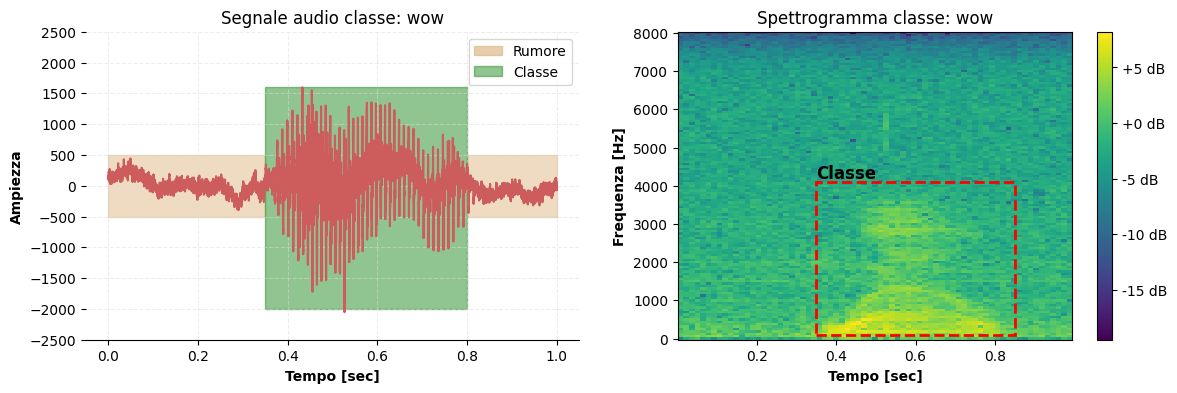

In [4]:
plot_rawaudio_and_spect(temporal_val, samples, times, frequencies, spectrogram, path_audio.split("/")[-2])

Questi due grafici, mostrano rispettivamente le onde dell'audio e uno spettrogramma. L'orecchio umano non è in grado di percepire tutte le frequenze rappresentate. Tramite l'uso di filter banks saremo in grado di mostrare quello che l'orecchio umano percepisce. (**DA CAMBIARE**)

Adesso ascoltiamo l'audio:

In [5]:
display(Audio(samples, rate=sample_rate, autoplay=False))

Questo audio non suona molto naturale, il che è dovuto al `sample_rate` (frequenza di campionamento) degli audio che stiamo trattando. In questo caso, l'audio è **campionato** a una **frequenza di 16kHz**, mentre siamo abituati ad ascoltare audio con frequenze di campionamento molto più alte. Ad esempio, la musica che ascoltiamo su YouTube o Spotify è solitamente campionata a 44.1kHz, ovvero 2.75 volte tanto.

Nonostante ciò, siamo comunque in grado di ascoltare l'audio campionato a 16kHz e, se necessario, potremmo ridurre ulteriormente la frequenza di campionamento a 8kHz per diminuire la dimensione del dataset e rimuovere alcune informazioni non essenziali.

L'audio presenta un leggero rumore, ma la parola "*wow*" è chiaramente udibile. Nel prossimo passaggio, ridurremo il rumore per rendere la parola ancora più chiara.

## I filter banks
I filter banks sono ideati per mimare la percezione umana dell'audio. Sono utilizzati per scomporre il segnale audio in diverse bande di frequenza, permettendo un'analisi dettagliata delle caratteristiche del segnale.

Per implementare i filter banks e condurre un'analisi corretta e approfondita dei segnali audio, ci siamo ispirati ai seguenti articoli:
- [Speech Processing for Machine Learning](https://haythamfayek.com/2016/04/21/speech-processing-for-machine-learning.html), che tratta i Filter Banks sia dal punto di vista teorico che pratico
- [Guide to Mel Frequency Cepstral Coefficient (MFCC)](http://practicalcryptography.com/miscellaneous/machine-learning/guide-mel-frequency-cepstral-coefficients-mfccs/), per comprendere il funzionamento teorico dei Filter Banks

Questi articoli ci hanno fornito le basi teoriche e pratiche necessarie per la nostra analisi.

Abbiamo strutturato il processo di generazione dei filter banks in **XXX** fasi:
- fase di pre-enfasi
- fase di framing
- fase di Hamming
- trasformata di Fourier

### Fase di pre-enfasi

La pre-enfasi conserva maggiormente l'ampiezza delle frequenze dell'audio più alte, migliorando il rapporto segnale-rumore. Un miglior rapporto segnale-rumore implica una riduzione del rumore di fondo, con un incremento dell'accuratezza nelle analisi successive.

Utilizzeremo un coefficiente standard di `pre-enfasi` pari a `0.97`, che consente una maggiore amplificazione delle alte frequenze rispetto a coefficienti più bassi.

I principali scopi del filtro di `pre-enfasi` sono:
- bilanciare lo spettro delle alte frequenze
- evitare problemi numerici durante la trasformazione di Fourier
- migliorare il rapporto segnale-rumore (SNR, Signal-to-Noise Ratio)

L'equazione utilizzata per applicare la pre-enfasi a un segnale audio $x$ è la seguente:
$$
y(t)=x(t)−αx(t−1)
$$

Dove:
- $y(t)$ è il segnale audio pre-enfatizzato al time step $t$
- $x(t)$ è il segnale audio originale al time step $t$
- $α$ è il coefficiente di pre-enfasi che controlla l'attenuazione delle basse frequenze rispetto alle alte frequenze
- $x(t−1)$ è il valore del segnale audio originale al time step $t-1$, ossia il campione precedente 

In questo caso $α$ determina quanto le frequenze alte vengono amplificate rispetto alle frequenze basse.

Applichiamo l'equazione e mostriamo i grafici precedenti con l'audio pre-enfatizzato.

In [6]:
pre_emphasis = 0.97
emphasized_signal = np.append(samples[0], samples[1:] - pre_emphasis * samples[:-1])
emph_frequencies, emph_times, emph_spectrogram = signal.spectrogram(emphasized_signal, sample_rate)

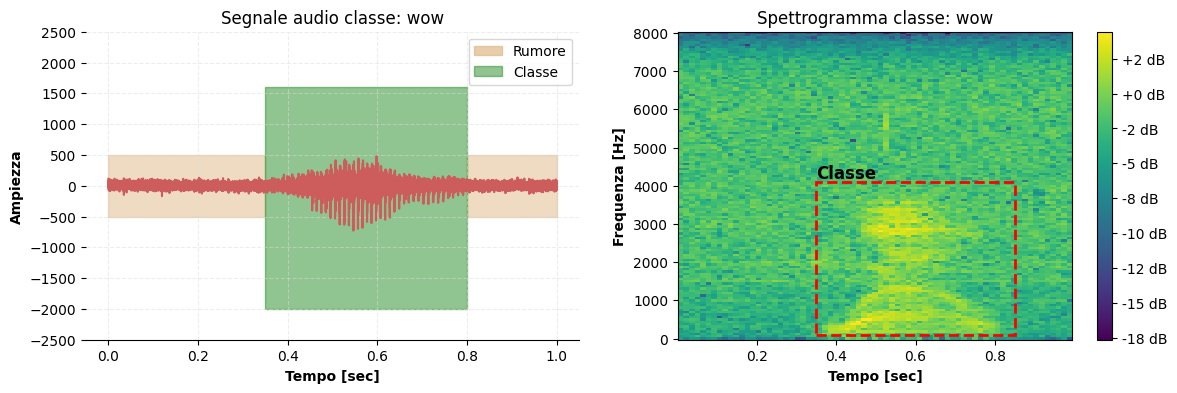

In [7]:
plot_rawaudio_and_spect(temporal_val, emphasized_signal, emph_times, emph_frequencies, emph_spectrogram, path_audio.split("/")[-2])

Notiamo un notevole cambiamento in entrambi i grafici. L'onda audio è ora più stabile, specialmente nella parte precedentemente rumorosa, dove le variazioni brusche sono state ridotte. 

Lo spettrogramma, invece, mostra un aumento della presenza delle frequenze alte. Questo è evidenziato dal colore giallo più intenso soprattutto nelle frequenze comprese tra 1000 e 4000 Hz.

Sentiamo l'audio:

In [8]:
display(Audio(emphasized_signal, rate=sample_rate, autoplay=False))

È evidente anche all'ascolto una riduzione del rumore e una maggiore chiarezza nella pronuncia delle parole.

### Fase di framing
Dopo aver completato la fase di pre-enfasi, procediamo con la fase di framing. Durante questa fase l'audio viene diviso in brevi segmenti. Questa suddivisione è fondamentale per catturare le variazioni delle frequenze nel tempo, e permette un'analisi dettagliata delle caratteristiche spettrali del segnale audio.

In sostanza, lo **scopo alla base** di questa fase è acquisire in breve tempo e singolarmente ogni lettera pronunciata, o più precisamente la sua componente fonetica. Per chiarire questo concetto possiamo provare a visualizzarlo.

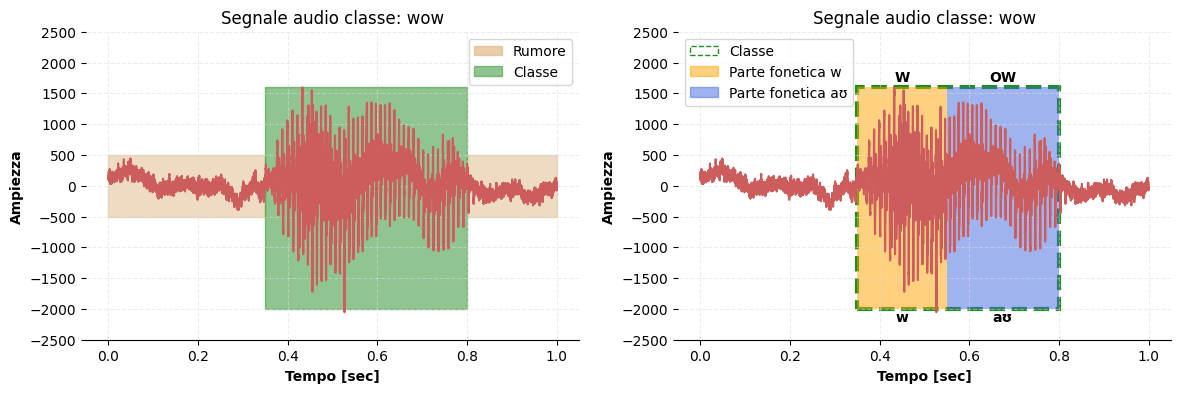

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(14, 4))

# audio normale
ax[0].plot(temporal_val, samples, label='nohash_1.wav', color="indianred")
# forzo la l'asse y
ax[0].set_yticks(range(-2500, 3000, 500))
# label e titolo
ax[0].set_ylabel('Ampiezza', fontweight="semibold")
ax[0].set_xlabel('Tempo [sec]', fontweight="semibold")
ax[0].set_title("Segnale audio classe: " + path_audio.split("/")[-2])
# nascondo bordi plot
ax[0].spines["left"].set_visible(False)
ax[0].spines["top"].set_visible(False)
ax[0].spines["right"].set_visible(False)
# area rumore
rumore_1 = mpatches.Rectangle((0, -500), width=0.35, height=1000, color='burlywood', alpha=0.5)
rumore_2 = mpatches.Rectangle((0.80, -500), width=0.20, height=1000, color='burlywood', alpha=0.5)
ax[0].add_patch(rumore_1)
ax[0].add_patch(rumore_2)
# area parola
classe = mpatches.Rectangle((0.35, -2000), width=0.45, height=3600, color="forestgreen", alpha=0.5)
ax[0].add_patch(classe)
#legenda
classe_handle = mpatches.Patch(color="forestgreen", alpha=0.5, label="Classe")
rumore_handle = mpatches.Patch(color="burlywood", alpha=0.7, label="Rumore")
ax[0].legend(handles=[rumore_handle, classe_handle])
# grid
ax[0].grid(True, color="gainsboro", linestyle="--", alpha=0.5)

# audio suddiviso in parti fonetiche
ax[1].plot(temporal_val, samples, label='nohash_1.wav', color="indianred")
# forzo la l'asse y
ax[1].set_yticks(range(-2500, 3000, 500))
# label e titolo
ax[1].set_ylabel('Ampiezza', fontweight="semibold")
ax[1].set_xlabel('Tempo [sec]', fontweight="semibold")
ax[1].set_title("Segnale audio classe: " + path_audio.split("/")[-2])
# nascondo bordi plot
ax[1].spines["left"].set_visible(False)
ax[1].spines["top"].set_visible(False)
ax[1].spines["right"].set_visible(False)
# area parola
classe = mpatches.Rectangle((0.35, -2000), width=0.45, height=3600, color="forestgreen",fill=None, linestyle="--", linewidth=3)
ax[1].add_patch(classe)
# area fonetica
fon_w = mpatches.Rectangle((0.35, -2000), width=0.20, height=3600, color="orange", alpha=0.5, linewidth=0)
fon_au = mpatches.Rectangle((0.55, -2000), width=0.25, height=3600, color="royalblue", alpha=0.5, linewidth=0)
ax[1].add_patch(fon_w)
ax[1].add_patch(fon_au)
# testi
# parola
ax[1].text((0.35 + 0.55)/2, 1700, "W", fontsize=10, fontweight="semibold", horizontalalignment="center")
ax[1].text((0.55 + 0.8)/2, 1700, "OW", fontsize=10, fontweight="semibold", horizontalalignment="center")
# fonetica
ax[1].text((0.35 + 0.55)/2, -2200, "w", fontsize=10, fontweight="semibold", horizontalalignment="center")
ax[1].text((0.55 + 0.8)/2, -2200, "aʊ", fontsize=10, fontweight="semibold", horizontalalignment="center")
#legenda
classe_handle = mpatches.Patch(color="forestgreen", label="Classe", fill=None, linestyle="--")
fon_w_handle = mpatches.Patch(color="orange", label="Parte fonetica w", alpha=0.5)
fon_au_handle = mpatches.Patch(color="royalblue", label="Parte fonetica aʊ", alpha=0.5)
ax[1].legend(handles=[classe_handle, fon_w_handle, fon_au_handle])
# grid
ax[1].grid(True, color="gainsboro", linestyle="--", alpha=0.5)

Sulla sinistra è visibile l'audio originale, con una porzione evidenziata manualmente in verde (la nostra classe/parola). Sulla destra, invece, l'audio è stato suddiviso in due parti fonetiche. Il principio fondamentale della fase di framing consiste nell'abilità di estrarre informazioni rilevanti utilizzando segmenti di segnale sufficientemente piccoli da contenere una singola parte fonetica.

È importante notare che il risultato ottenuto non sarà identico all'immagine mostrata sulla destra, poiché i segmenti saranno notevolmente più piccoli e numerosi.

Nella maggior parte dei casi, eseguire la **trasformata di Fourier** sull'intero segnale audio non è ottimale poiché le frequenze possono variare rapidamente nel tempo. È preferibile considerare brevi periodi di tempo come stazionari e applicare la trasformata di Fourier su di essi. Questo fornisce una buona approssimazione delle frequenze nel fotogramma temporale considerato.

Per la segmentazione del nostro segnale audio, adottiamo gli standard tipici solitamente impiegati per il processamento del linguaggio:
- `frame_size` di 25ms, indica la durata di ciascun frame
- `frame_stride` di 10ms, indica l'intervallo di tempo tra l'inizio di un frame e l'inizio del successivo

Ad esempio, con `frame_size` di **25ms** e `frame_stride` di **10ms**, ogni nuovo frame inizia 10ms dopo l'inizio del precedente, creando un overlap di **15ms** tra i frame adiacenti.

In [10]:
frame_size = 0.025
frame_stride = 0.01

frame_length, frame_step = frame_size * sample_rate, frame_stride * sample_rate  # Convertiamo da secondi a samples
signal_length = len(emphasized_signal)

# Per rendere il calcolo più agevole le due variabili vengono convertite e arrotondate in numeri interi
frame_length = int(round(frame_length))
frame_step = int(round(frame_step))

num_frames = int(np.ceil(float(np.abs(signal_length - frame_length)) / frame_step))  #Il numero di frame viene calcolato come il rapporto tra la lunghezza effettiva del segnale e il singolo step
#in questo modo siamo sicuri che ci sia almeno un frame anche se il segnale è più corto di frame_length

pad_signal_length = num_frames * frame_step + frame_length
z = np.zeros((pad_signal_length - signal_length))
pad_signal = np.append(emphasized_signal, z) # Pad Signal serve per essere sicuri che tutti i samples abbiano la stessa lunghezza

indices = np.tile(np.arange(0, frame_length), (num_frames, 1)) + np.tile(np.arange(0, num_frames * frame_step, frame_step), (frame_length, 1)).T
frames = pad_signal[indices.astype(np.int32, copy=False)]

Una volta calcolati i frame, possiamo visualizzare ciò che abbiamo approssimativamente ottenuto.

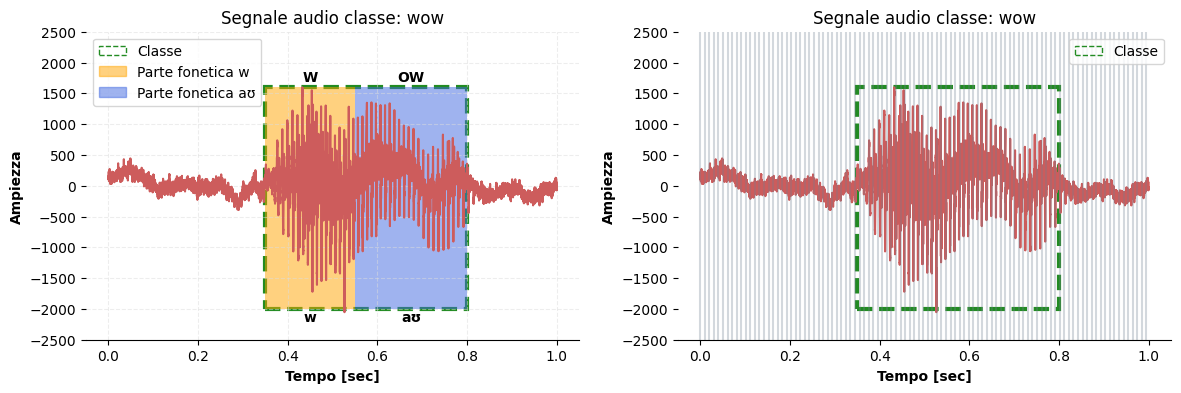

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(14, 4))

# audio suddiviso in parti fonetiche
ax[0].plot(temporal_val, samples, label='nohash_1.wav', color="indianred")
# forzo la l'asse y
ax[0].set_yticks(range(-2500, 3000, 500))
# label e titolo
ax[0].set_ylabel('Ampiezza', fontweight="semibold")
ax[0].set_xlabel('Tempo [sec]', fontweight="semibold")
ax[0].set_title("Segnale audio classe: " + path_audio.split("/")[-2])
# nascondo bordi plot
ax[0].spines["left"].set_visible(False)
ax[0].spines["top"].set_visible(False)
ax[0].spines["right"].set_visible(False)
# area parola
classe = mpatches.Rectangle((0.35, -2000), width=0.45, height=3600, color="forestgreen",fill=None, linestyle="--", linewidth=3)
ax[0].add_patch(classe)
# area fonetica
fon_w = mpatches.Rectangle((0.35, -2000), width=0.20, height=3600, color="orange", alpha=0.5, linewidth=0)
fon_au = mpatches.Rectangle((0.55, -2000), width=0.25, height=3600, color="royalblue", alpha=0.5, linewidth=0)
ax[0].add_patch(fon_w)
ax[0].add_patch(fon_au)
# testi
# parola
ax[0].text((0.35 + 0.55)/2, 1700, "W", fontsize=10, fontweight="semibold", horizontalalignment="center")
ax[0].text((0.55 + 0.8)/2, 1700, "OW", fontsize=10, fontweight="semibold", horizontalalignment="center")
# fonetica
ax[0].text((0.35 + 0.55)/2, -2200, "w", fontsize=10, fontweight="semibold", horizontalalignment="center")
ax[0].text((0.55 + 0.8)/2, -2200, "aʊ", fontsize=10, fontweight="semibold", horizontalalignment="center")
#legenda
classe_handle = mpatches.Patch(color="forestgreen", label="Classe", fill=None, linestyle="--")
fon_w_handle = mpatches.Patch(color="orange", label="Parte fonetica w", alpha=0.5)
fon_au_handle = mpatches.Patch(color="royalblue", label="Parte fonetica aʊ", alpha=0.5)
ax[0].legend(handles=[classe_handle, fon_w_handle, fon_au_handle])
# grid
ax[0].grid(True, color="gainsboro", linestyle="--", alpha=0.5)


# audio suddiviso in parti fonetiche
ax[1].plot(temporal_val, samples, label='nohash_1.wav', color="indianred")
# forzo la l'asse y
ax[1].set_yticks(range(-2500, 3000, 500))
# label e titolo
ax[1].set_ylabel('Ampiezza', fontweight="semibold")
ax[1].set_xlabel('Tempo [sec]', fontweight="semibold")
ax[1].set_title("Segnale audio classe: " + path_audio.split("/")[-2])
# nascondo bordi plot
ax[1].spines["left"].set_visible(False)
ax[1].spines["top"].set_visible(False)
ax[1].spines["right"].set_visible(False)
# area parola
classe = mpatches.Rectangle((0.35, -2000), width=0.45, height=3600, color="forestgreen",fill=None, linestyle="--", linewidth=3)
ax[1].add_patch(classe)
#legenda
classe_handle = mpatches.Patch(color="forestgreen", label="Classe", fill=None, linestyle="--")
ax[1].legend(handles=[classe_handle])
# grid
# linee frame
for i in range(num_frames + 1):
    ax[1].axvline(i * 0.01015, alpha=0.3, color="slategrey")

plt.show()


Il grafico a destra illustra la suddivisione dell'audio in segmenti. È importante sottolineare che questa rappresentazione è approssimativa e non deve essere considerata precisa, ma piuttosto come un mezzo per comprendere il processo eseguito e il suo scopo.

Mostriamo alcuni segmenti:

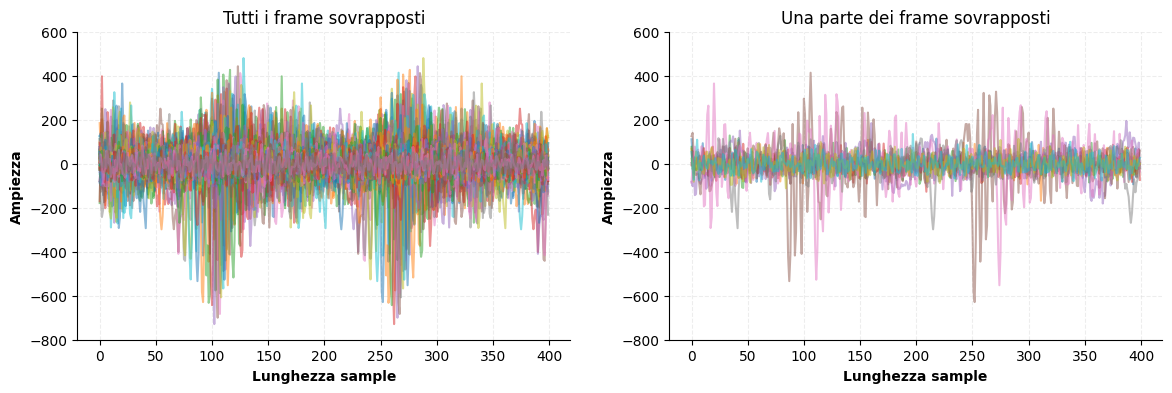

In [12]:
fig, ax = plt.subplots(1, 2, figsize=(14, 4))

for i in range(0, num_frames):
    ax[0].plot(frames[i], alpha=0.5)  # Usa alpha per la trasparenza

ax[0].set_yticks(range(-800, 800, 200))
ax[0].set_title('Tutti i frame sovrapposti')
ax[0].set_xlabel('Lunghezza sample', fontweight="semibold")
ax[0].set_ylabel('Ampiezza', fontweight="semibold")
# nascondo bordi plot
ax[0].spines["top"].set_visible(False)
ax[0].spines["right"].set_visible(False)
# grid
ax[0].grid(True, color="gainsboro", linestyle="--", alpha=0.5)

# parte dei frame sovrapposti
for i in range(0, num_frames, 10):
    ax[1].plot(frames[i], alpha=0.5)  # Usa alpha per la trasparenza

ax[1].set_yticks(range(-800, 800, 200))
ax[1].set_title('Una parte dei frame sovrapposti')
ax[1].set_xlabel('Lunghezza sample', fontweight="semibold")
ax[1].set_ylabel('Ampiezza', fontweight="semibold")
# nascondo bordi plot
ax[1].spines["top"].set_visible(False)
ax[1].spines["right"].set_visible(False)
# grid
ax[1].grid(True, color="gainsboro", linestyle="--", alpha=0.5)

plt.show()

Nei due grafici rappresentati, da sinistra verso destra, abbiamo rispettivamente tutti i frame sovrapposti e soltanto una selezione (ogni 10) dei frame sovrapposti. È evidente la presenza di numerosi segmenti con ampiezze principalmente basse, i quali potrebbero essere scartati poiché privi di informazioni significative.

È chiaro come risulti più agevole estrarre informazioni rilevanti dopo aver completato la fase di framing.

**Effettivamente ci serve mostrare questo grafico? Parlarne con Andrea, Theo, Giovi, e il professore.**

### Fase di Hamming

Dopo aver suddiviso i segnali audio in segmenti, è necessario applicare una **funzione finestra**, che ci permette di ridurre la dispersione spettrale. 

Una funzione finestra è una funzione (o forma) la quale risulta essere diversa da zero per un determinato intervallo e pari a zero prima e dopo tale intervallo. Questa funzione finestra viene moltiplicata per un segnale, producendo un'uscita pari a zero eccetto durante l'intervallo in cui la finestra è diversa da zero, permettendo di esporre il segnale solo in quel periodo.

Un esempio semplice è una finestra rettangolare, in principio pari a zero, succesivamente a uno, e quindi nuovamente a zero. Il segnale ottenuto dopo l'applicazione della finestra sarà udibile solo durante l'intervallo in cui viene moltiplicato per uno, cioè durante il periodo in cui la finestra rettangolare è attiva.

Esistono diversi tipi di forme di una finestra e noi utilizzeremo nello specifico la finestra di Hamming, definita dalla seguente espressione:
$$
w[n] = 0.54 - 0.46 \cos\left(\frac{2\pi n}{N-1}\right)
$$
per $0 ≤ n ≤ N - 1$, dove $N$ è la lunghezza della finestra.

Definiamo noi stessi la funzione di Hamming, invece di utilizzare quella di numpy:

In [13]:
# Implementiamo la funzione di Hamming
def makeHamming(M):
    R = (( M - 1 ) / 2 , M / 2)[M % 2 == 0]
    w = (np.hamming(M), np.hamming(M + 1))[M % 2 == 0]
    if M % 2 != 0:
        w[0] = w[0]/2
        w[M-1] = w[M-1]/2
    else:
        w = w[:M]
        
    return w

# @link Medium

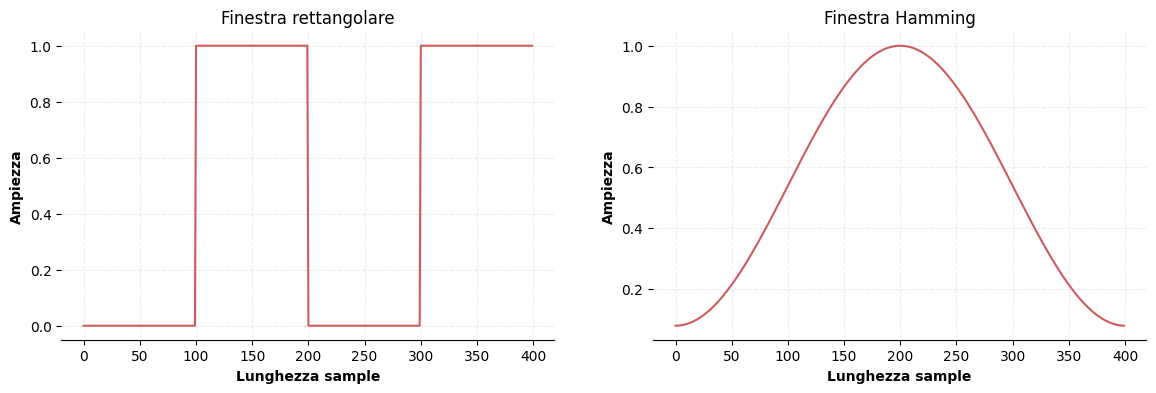

In [14]:
fig, ax = plt.subplots(1, 2, figsize=(14, 4))

rectangular_window = (np.concatenate((np.zeros(frame_length // 4),
                                      np.ones(frame_length // 4),
                                     np.zeros(frame_length // 4),
                                     np.ones(frame_length // 4))))
hamming_window = makeHamming(frame_length)

# window function rettangolare
ax[0].plot(rectangular_window, c="indianred")
# titolo e label
ax[0].set_title("Finestra rettangolare")
ax[0].set_xlabel('Lunghezza sample', fontweight="semibold")
ax[0].set_ylabel('Ampiezza', fontweight="semibold")
# nascondo i bordi del plot
ax[0].spines["left"].set_visible(False)
ax[0].spines["top"].set_visible(False)
ax[0].spines["right"].set_visible(False)
# grid
ax[0].grid(True, color="gainsboro", linestyle="--", alpha=0.5)

# window function hamming
ax[1].plot(hamming_window, c="indianred")
# titolo e label
ax[1].set_title("Finestra Hamming")
ax[1].set_xlabel('Lunghezza sample', fontweight="semibold")
ax[1].set_ylabel('Ampiezza', fontweight="semibold")
# nascondo i bordi del plot
ax[1].spines["left"].set_visible(False)
ax[1].spines["top"].set_visible(False)
ax[1].spines["right"].set_visible(False)
# grid
ax[1].grid(True, color="gainsboro", linestyle="--", alpha=0.5)

plt.show()

La finestra rettangolare ha un comportamento "on/off", dove il segnale è completamente presente durante l'intervallo attivo e assente al di fuori di esso. Diversamente, la finestra di Hamming fornisce un graduale smorzamento ai bordi, riducendo gli artefatti e la dispersione spettrale nel segnale.

In [15]:
frames_rect_window = frames * rectangular_window
frames_hamming_window = frames * hamming_window

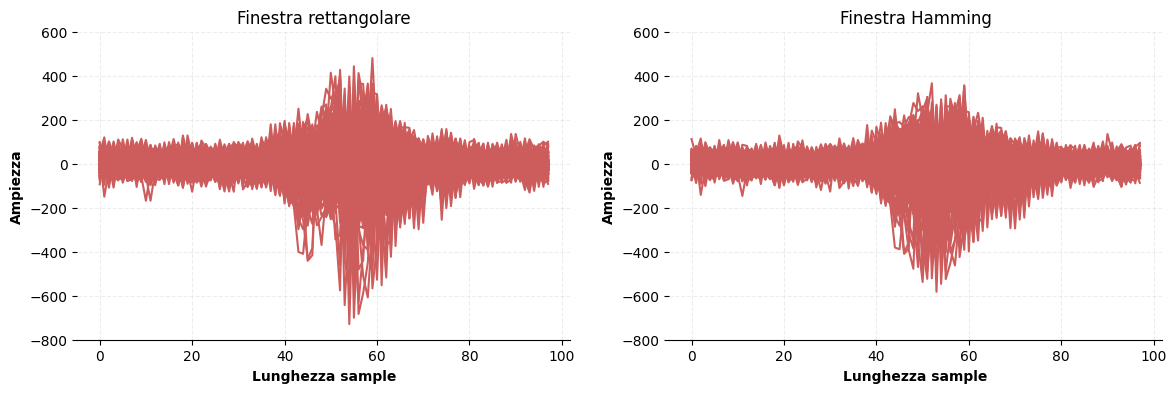

In [16]:
fig, ax = plt.subplots(1, 2, figsize=(14, 4))

# window function rettangolare
ax[0].plot(frames_rect_window, c="indianred")
# titolo e label
ax[0].set_title("Finestra rettangolare")
ax[0].set_xlabel('Lunghezza sample', fontweight="semibold")
ax[0].set_ylabel('Ampiezza', fontweight="semibold")
# nascondo i bordi del plot
ax[0].spines["left"].set_visible(False)
ax[0].spines["top"].set_visible(False)
ax[0].spines["right"].set_visible(False)
# y ticks
ax[0].set_yticks(range(-800, 800, 200))
# grid
ax[0].grid(True, color="gainsboro", linestyle="--", alpha=0.5)

# window function hamming
ax[1].plot(frames_hamming_window, c="indianred")
# titolo e label
ax[1].set_title("Finestra Hamming")
ax[1].set_xlabel('Lunghezza sample', fontweight="semibold")
ax[1].set_ylabel('Ampiezza', fontweight="semibold")
# nascondo i bordi del plot
ax[1].spines["left"].set_visible(False)
ax[1].spines["top"].set_visible(False)
ax[1].spines["right"].set_visible(False)
# y ticks
ax[1].set_yticks(range(-800, 800, 200))
# grid
ax[1].grid(True, color="gainsboro", linestyle="--", alpha=0.5)

plt.show()

Come evidenziato nel grafico, l'applicazione della finestra di Hamming restringe i valori del segnale all'intervallo $[0, N-1]$, mentre l'applicazione della finestra rettangolare da noi creata produce una limitazione dei valori in modo diverso.

È da notare che la finestra di Hamming si dimostra superiore in quanto contribuisce a una miglior rappresentazione spettrale del segnale audio, riducendo le perdite causate dalle discontinuità.

### Trasformata di Fourier
Per ottenere un risultato ottimale nel processamento dei segnali audio, è una buona pratica applicare la Trasformata di Fourier. Questa trasformata viene applicata a ogni segmento audio per calcolare lo spettro delle frequenze, scomponendo il segnale audio in una somma di sinusoidi e velocizzando il calcolo.

La Trasformata di Fourier permette di identificare le principali frequenze presenti in un segnale audio. Questa particolare trasformata è chiamata `N-point FFT` (Fast Fourier Transform), dove $N$ è tipicamente una potenza di $2$, come $256$ o $512$. Nel nostro caso, abbiamo scelto di utilizzare `N = 512`. Possiamo quindi calcolare l'ampiezza della FFT e salvare il suo valore nella variabile `mag_frames`.

Con l'ausilio della Trasformata di Fourier, possiamo calcolare lo spettro delle potenze del segnale audio, utilizzando la seguente equazione:
$$
P = \frac{| \text{FFT}(x_i) |^2}{N}
$$

dove $x_i$ è l' $i$-esimo frame del segnale audio $x$.

In [17]:
NFFT = 512 # oppure 256
mag_frames = np.absolute(np.fft.rfft(frames, NFFT))  # Magnitudo della FFT
pow_frames = ((1.0 / NFFT) * ((mag_frames) ** 2))  # Spettro delle potenze

## Computazione Filter Banks
A questo punto, possiamo creare i Filter Banks, che si ottengono applicando dei filtri triangolari. Tipicamente, si utilizzano 40 filtri, e anche noi abbiamo scelto questo standard.

I filtri vengono applicati su una scala particolare chiamata scala mel. La scala mel viene impiegata per convertire le frequenze (f) in mel (m). Questo metodo è progettato per discriminare meglio le basse frequenze e essere meno discriminante verso le alte frequenze, poiché l'orecchio umano è naturalmente più sensibile alle basse frequenze.

Per convertire le frequenze in mel e viceversa, si utilizzano le seguenti equazioni:

$$\ m = 2595 \log_{10} \left(1 + \frac{f}{700}\right)$$

$$\ f = 700 \left(\frac{10m}{2595} - 1\right)$$

Ogni filter bank ha una forma triangolare, che raggiunge il valore di 1 al centro della frequenza e decresce fino a raggiungere 0 al centro dei due filtri adiacenti.

Definiamo la funzione `hztomel` che ci tornerà utile durante la computazione dei filter banks:

In [18]:
def hztomel(hz):
    return (2595 * np.log10(1 + hz / 700))

def meltohz(mel):
    return (700 * (10**(mel / 2595) - 1))

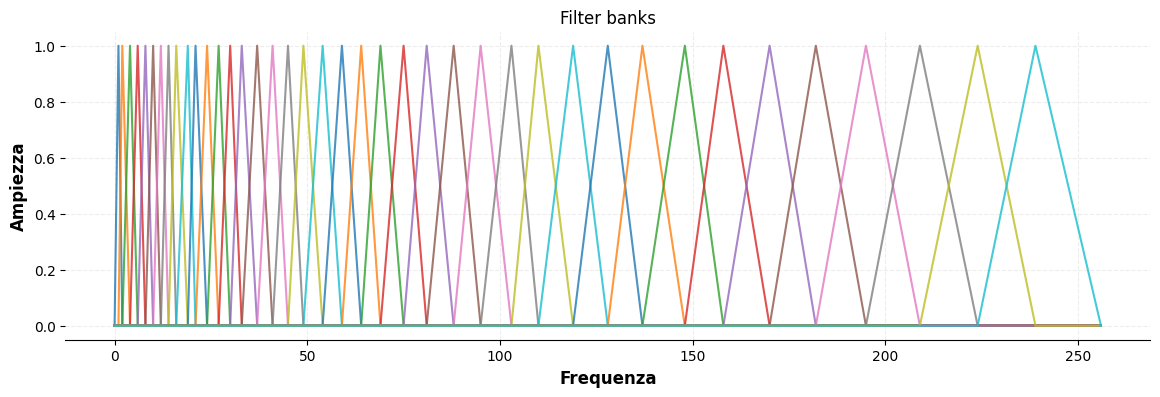

In [19]:
# indichiamo il numero di filtri da computare
nfilt = 40

# convertiamo hz in mel
low_freq_mel = hztomel(0)
high_freq_mel = hztomel(sample_rate / 2) 

# calcolo i punti di frequenza sui quali vengono costruiti i filter banks
mel_points = np.linspace(low_freq_mel, high_freq_mel, nfilt + 2) # genero i punti mel
hz_points = meltohz(mel_points)  # Convert Mel to Hz

# calcolo le posizioni dei punti di frequenza dei bin
bin = np.floor((NFFT + 1) * hz_points / sample_rate)

# inizializzo i filter banks
fbank = np.zeros((nfilt, int(np.floor(NFFT / 2 + 1))))
# costruisco i filtri triangolari, ogni filtro è centrato in una frequenza specifica di "bin" e si estende sui bin vicini
for m in range(1, nfilt + 1):
    f_m_minus = int(bin[m - 1]) 
    f_m = int(bin[m]) 
    f_m_plus = int(bin[m + 1])  

    for k in range(f_m_minus, f_m):
        fbank[m - 1, k] = (k - bin[m - 1]) / (bin[m] - bin[m - 1])
    for k in range(f_m, f_m_plus):
        fbank[m - 1, k] = (bin[m + 1] - k) / (bin[m + 1] - bin[m])

# in questo momento invece calcoliamo i filter banks per i segmenti di audio, utilizzando i filtri triangolari appena creati
filter_banks = np.dot(pow_frames, fbank.T)
filter_banks = np.where(filter_banks == 0, np.finfo(float).eps, filter_banks)
filter_banks = 20 * np.log10(filter_banks)

# mostriamo i filterbanks generati
fig, ax = plt.subplots(figsize=(14,4))

# definisco label
ax.set_title("Filter banks")
ax.set_ylabel('Ampiezza', fontweight="semibold", fontsize=12)
ax.set_xlabel('Frequenza', fontweight="semibold", fontsize=12)
# nascondo i bordi del plot
ax.spines["left"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
# griglia
ax.grid(True, color="gainsboro", linestyle="--", alpha=0.5)

for n in range(fbank.shape[0]):
    ax.plot(fbank[n], alpha=0.8)

plt.show()

I Filter Banks verranno successivamente applicati allo spettrogramma dell'audio campione utilizzato all'inizio del Notebook.

Lo spettrogramma dovrebbe enfatizzare maggiormente le caratteristiche principale dell'audio, e di conseguenza un modello convolutivo dovrebbe avere delle prestazioni maggiori con questo nuovo tipo di spettrogrammi.

In [20]:
# spettrogramma originale
og_frequencies, og_times, og_spectrogram = signal.spectrogram(samples, sample_rate)
fb_time_frames = np.arange(0, num_frames + 1) * frame_stride

In [21]:
# questa funziona non può essere utilizzata totalmente per qualsiasi audio, ma soltanto per quello da noi scelto (solo ricognizione)
# è stata creata per evitare ridondanza
def plot_spect_vs_spect(name1, spect_times_1, spect_freq_1, spect_1, name2, spect_times_2, spect_freq_2, spect_2, recognition=True, cmap=False):
    # primo spettrogramma
    fig, ax = plt.subplots(1, 2, figsize=(14, 4))
    # primo spettrogramma
    if cmap:
        spect1 = ax[0].pcolormesh(spect_times_1, spect_freq_1, spect_1, cmap="jet")
    else:
        spect1 = ax[0].pcolormesh(spect_times_1, spect_freq_1, spect_1)
    # imposto la barra dello spettrogramma
    fig.colorbar(spect1, ax=ax[0], format='%+2.0f dB')
    # imposto le label
    ax[0].set_ylabel('Frequenza [Hz]', fontweight="semibold") 
    ax[0].set_xlabel('Tempo [sec]', fontweight="semibold")
    ax[0].set_title(name1)

    if recognition:
        # ricognizione parola
        if cmap:
            classe_spect_1 = mpatches.Rectangle((0.35, 100), width=0.50, height=4000, linestyle="--", linewidth=2, fill=None, color="blue")
        else:
            classe_spect_1 = mpatches.Rectangle((0.35, 100), width=0.50, height=4000, linestyle="--", linewidth=2, fill=None, color="red")
        ax[0].add_patch(classe_spect_1)
        ax[0].text(0.35, 4200, "Classe", fontsize=12, fontweight="semibold")

    
    # secondo spettrogramma
    if cmap:
        spect2 = ax[1].pcolormesh(spect_times_2, spect_freq_2, spect_2, cmap="jet")
    else:
        spect2 = ax[1].pcolormesh(spect_times_2, spect_freq_2, spect_2)

    # imposto la barra dello spettrogramma
    fig.colorbar(spect2, ax=ax[1], format='%+2.0f dB')
    # imposto le label
    ax[1].set_title(name2)
    ax[1].set_ylabel('Frequenza [Hz]', fontweight="semibold")
    ax[1].set_xlabel('Tempo [s]', fontweight="semibold")

    if recognition:
        if cmap:
            classe_spect_2 = mpatches.Rectangle((0.35, 100), width=0.50, height=4000, linestyle="--", linewidth=2, fill=None, color="blue")
        else:
            classe_spect_2 = mpatches.Rectangle((0.35, 100), width=0.50, height=4000, linestyle="--", linewidth=2, fill=None, color="red")
        ax[1].add_patch(classe_spect_2)
        ax[1].text(0.35, 4200, "Classe", fontsize=12, fontweight="semibold")

    plt.show()

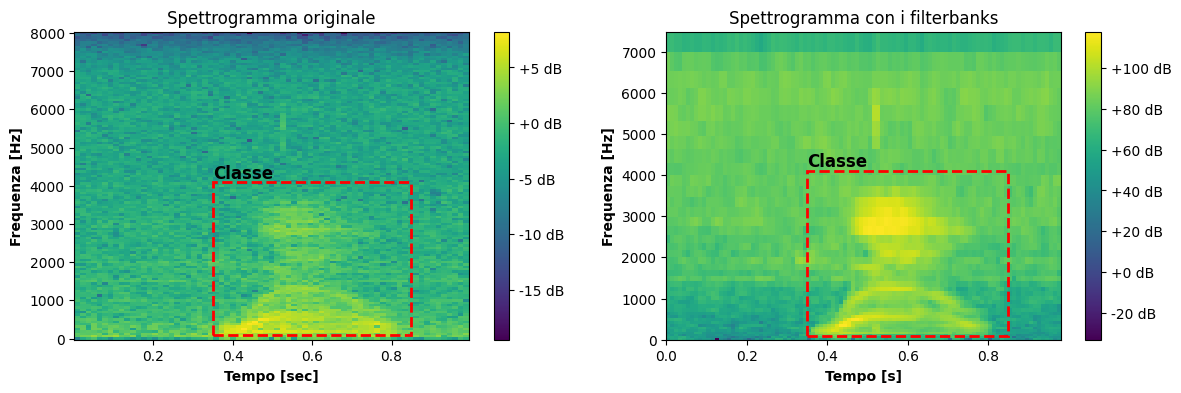

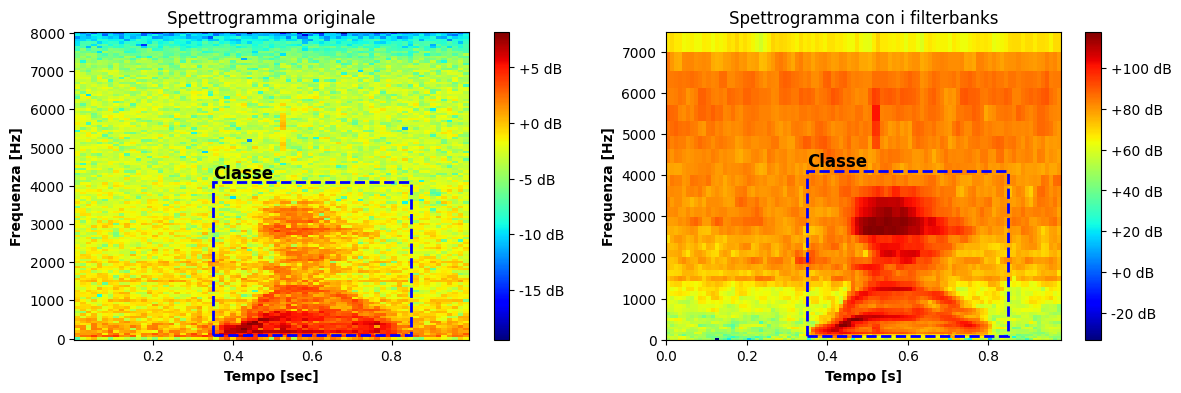

In [22]:
plot_spect_vs_spect("Spettrogramma originale", og_times, og_frequencies, np.log(og_spectrogram), 
                    "Spettrogramma con i filterbanks", fb_time_frames, hz_points[:-1], filter_banks.T)
plot_spect_vs_spect("Spettrogramma originale", og_times, og_frequencies, np.log(og_spectrogram), 
                    "Spettrogramma con i filterbanks", fb_time_frames, hz_points[:-1], filter_banks.T, cmap=True)

Possiamo osservare una notevole differenza tra lo spettrogramma originale e lo spettrogramma con i filterbanks applicati. In quest'ultimo è più chiaro dove sia presente la classe

La differenza è ancora più notabile utilizzando il parametro `cmap=jet`, dove la label viene evidenziata di rosso e ha un impatto visivo significativo. Molto probabilmente un modello convolutivo riuscirebbe a prendere più informazioni dallo spettrogramma con i filterbanks.

### Normalizzazione filter banks
Qualora fosse necessario è possibile normalizzare i filter banks per migliorare la qualità delle frequenze, di conseguenza ottenere uno spettrogramma che risulti più pulito e dia ulteriore importanza alle alte frequenze.

In [23]:
#filter banks normalizzati
normalized_filter_banks = filter_banks - (np.mean(filter_banks, axis=0) + 1e-8) #normalizzazione con la media

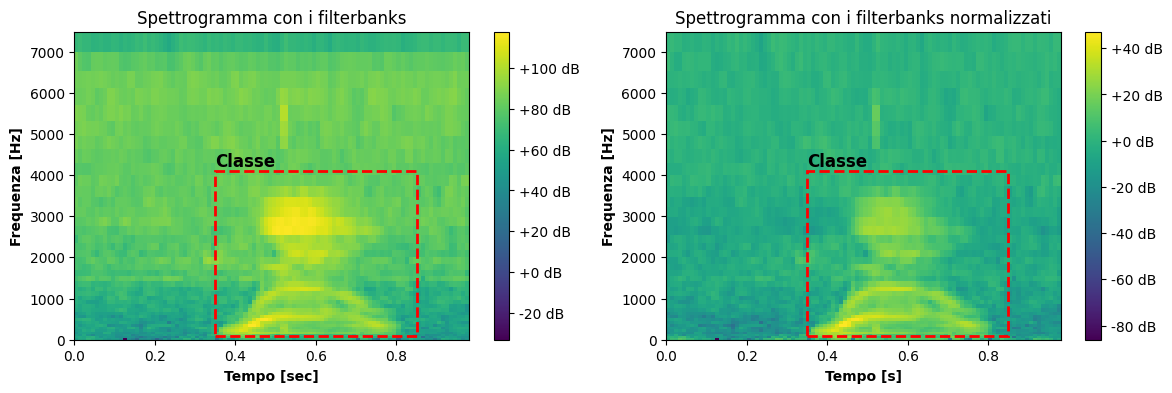

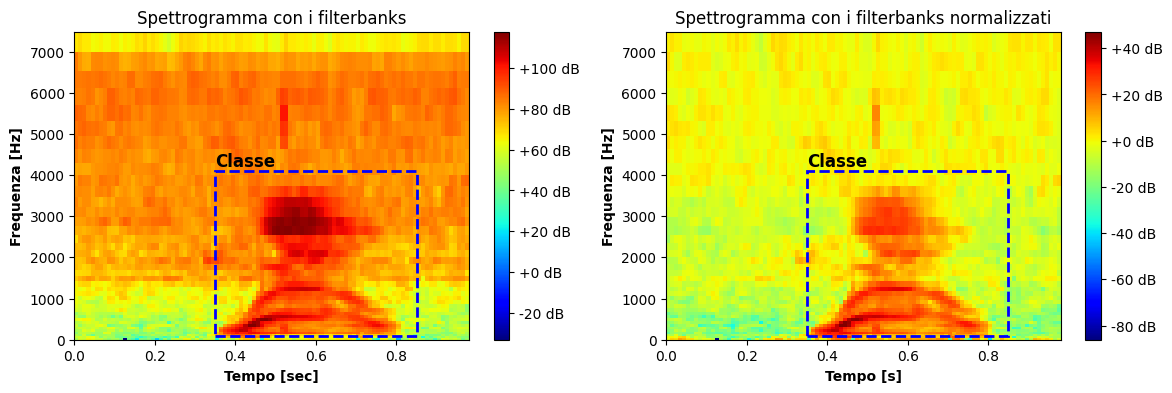

In [24]:
plot_spect_vs_spect("Spettrogramma con i filterbanks", fb_time_frames, hz_points[:-1], filter_banks.T, 
                    "Spettrogramma con i filterbanks normalizzati", fb_time_frames, hz_points[:-1], normalized_filter_banks.T)
plot_spect_vs_spect("Spettrogramma con i filterbanks", fb_time_frames, hz_points[:-1], filter_banks.T, 
                    "Spettrogramma con i filterbanks normalizzati", fb_time_frames, hz_points[:-1], normalized_filter_banks.T, cmap=True)

## Mel-Frequency Cepstral Coefficients (MFCCs)
Dalla fase precedente è emerso che i filter banks computati sono altamente correlati tra loro, il che potrebbe essere problematico a seconda del modello che utilizziamo. Per decorrelare i filter banks possiamo applicare la **DCT** (Discrete Cosine Transform) e ottenere una rappresentazione compatta e informativa delle caratteristiche del segnale. 

Mel-frequency cepstrum è una tecnica che combina trasformazioni matematiche per rappresentare un segnale audio in grado di riflettere meglio la percezione umana del suono.
Questo processo implica la **conversione del segnale** in un insieme di **coefficienti**, i quali rappresentano la *potenza* del segnale su una scala di frequenza non lineare (mel), a cui viene successivamente applicata la DCT. 

In [25]:
num_ceps = 12 # numero di Cepstral Coefficients
cep_lifter = 22
mfcc = scipy.dct(filter_banks, type=2, axis=1, norm='ortho')[:, 1 : (num_ceps + 1)] #calcoliamo i Mel-Frequency Cepstral Coefficients

(nframes, ncoeff) = mfcc.shape
n = np.arange(ncoeff)
lift = 1 + (cep_lifter / 2) * np.sin(np.pi * n / cep_lifter)
mfcc *= lift

mfcc_time_frames = np.arange(0, num_frames) * frame_stride

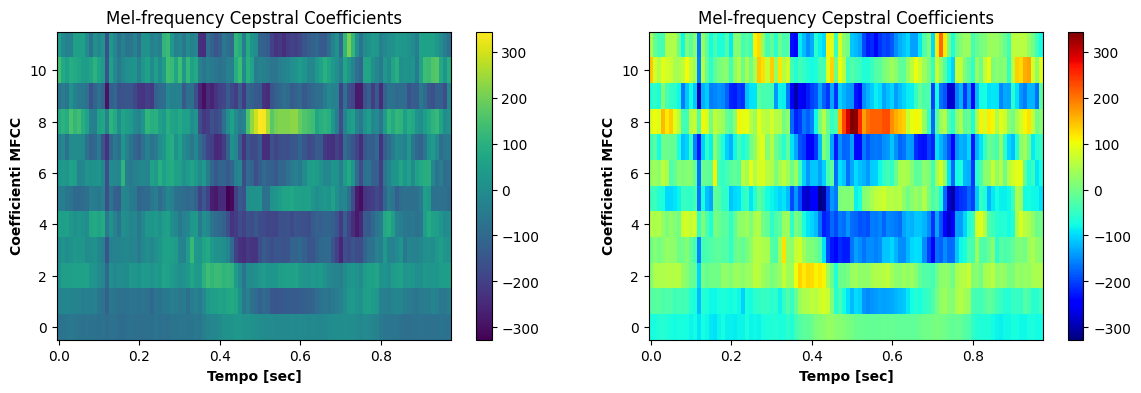

In [26]:
fig, ax = plt.subplots(1, 2, figsize=(14, 4))

mfcc_spect_1 = ax[0].pcolormesh(mfcc_time_frames, range(num_ceps), mfcc.T)
# imposto la barra dello spettrogramma
fig.colorbar(mfcc_spect_1, ax=ax[0])
# imposto le label
ax[0].set_ylabel('Coefficienti MFCC', fontweight="semibold") 
ax[0].set_xlabel('Tempo [sec]', fontweight="semibold")
ax[0].set_title("Mel-frequency Cepstral Coefficients")

mfcc_spect_2 = ax[1].pcolormesh(mfcc_time_frames, range(num_ceps), mfcc.T, cmap="jet")
# imposto la barra dello spettrogramma
fig.colorbar(mfcc_spect_2, ax=ax[1])
# imposto le label
ax[1].set_ylabel('Coefficienti MFCC', fontweight="semibold") 
ax[1].set_xlabel('Tempo [sec]', fontweight="semibold")
ax[1].set_title("Mel-frequency Cepstral Coefficients")

plt.show()

## Normalized Mel-Frequency Cepstral Coefficients (MFCCs)
Anche per i coefficienti MFCC, è possibile applicare una normalizzazione basata sulla media, se necessario. Questo processo mira a migliorare la qualità delle frequenze nell'analisi audio, producendo uno spettrogramma più pulito e conferendo maggiore importanza alle alte frequenze.

In [27]:
#MFCC normalizzati
mfcc -= (np.mean(mfcc, axis=0) + 1e-8)
normalized_mfcc = mfcc

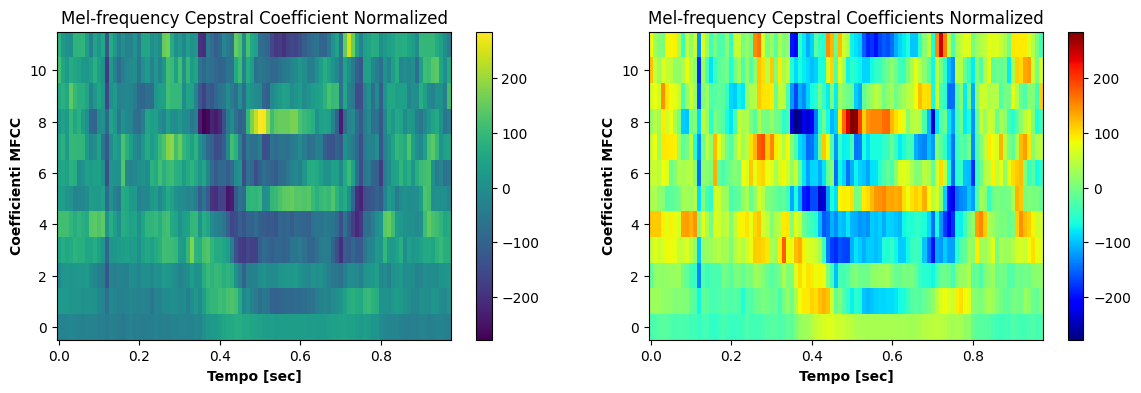

In [28]:
fig, ax = plt.subplots(1, 2, figsize=(14, 4))

normalized_mfcc_spect_1 = ax[0].pcolormesh(mfcc_time_frames, range(num_ceps), normalized_mfcc.T)
# imposto la barra dello spettrogramma
fig.colorbar(normalized_mfcc_spect_1, ax=ax[0])
# imposto le label
ax[0].set_ylabel('Coefficienti MFCC', fontweight="semibold") 
ax[0].set_xlabel('Tempo [sec]', fontweight="semibold")
ax[0].set_title("Mel-frequency Cepstral Coefficient Normalized")

normalized_mfcc_spect_2 = ax[1].pcolormesh(mfcc_time_frames, range(num_ceps), normalized_mfcc.T, cmap="jet")
# imposto la barra dello spettrogramma
fig.colorbar(normalized_mfcc_spect_2, ax=ax[1])
# imposto le label
ax[1].set_ylabel('Coefficienti MFCC', fontweight="semibold") 
ax[1].set_xlabel('Tempo [sec]', fontweight="semibold")
ax[1].set_title("Mel-frequency Cepstral Coefficients Normalized")

plt.show()

# Conversione dataset

In [82]:
class DatasetConverter:
    def __init__(self, dataset):
        self.dataset = dataset

    def convert(self, option):
        available_options = ['spettrogramma', 'filterbanks', 'mfcc']

        if option == available_options[0]:
            return self.get_spectrogram_dataset()
        elif option == available_options[1]:
            return self.get_filterbanks_dataset()
        elif option == available_options[2]:
            return self.get_mfcc_dataset()
        else:
            raise ValueError(f"Opzione non disponibile: inserire una delle seguenti opzioni: {available_options}")

    def squeeze(self, audio, labels):
        audio = tf.squeeze(audio, axis=-1)
        return audio, labels
    
    def get_spectrogram(self, waveform):
    # applichiamo la short-time Fourier transorm
        spectrogram = tf.signal.stft(waveform, frame_length=255, frame_step=128)
        spectrogram = tf.abs(spectrogram)
        
        return spectrogram[..., tf.newaxis]
    
    def get_spectrogram_dataset(self):
        # squeeze
        self.dataset = self.dataset.map(self.squeeze, tf.data.AUTOTUNE)
        self.dataset = self.dataset.map(lambda x, y: (self.get_spectrogram(x), y), num_parallel_calls=tf.data.AUTOTUNE)
        
        return self.dataset

    def pre_emphasis(self, samples, pre_emphasis_rate=0.97):
        # Apply pre-emphasis
        samples = tf.concat([samples[:, :1], samples[:, 1:] - pre_emphasis_rate * samples[:, :-1]], axis=1)
        
        return samples

    def framing_phase(self, emphasized_audio, sample_rate=16000, frame_size=0.025, frame_stride=0.01, audio_length=16000):        
        frame_length, frame_step = int(frame_size * sample_rate), int(frame_stride * sample_rate)

        num_frames = int(np.ceil(float(np.abs(audio_length - frame_length)) / frame_step))

        pad_audio_length = num_frames * frame_step + frame_length
        z = np.zeros((pad_audio_length - audio_length))
        pad_audio = np.append(emphasized_audio, z)

        indices = np.tile(np.arange(0, frame_length), (num_frames, 1)) + np.tile(np.arange(0, num_frames * frame_step, frame_step), (frame_length, 1)).T

        frames = pad_audio[indices.astype(np.int32, copy=False)]
        
        return frames

    def framing_phase_tf(self, emphasized_audio):
        frames = tf.numpy_function(self.framing_phase, [emphasized_audio], tf.double)
        return frames

    def makeHamming(self, M):
        R = (( M - 1 ) / 2 , M / 2)[M % 2 == 0]
        w = (np.hamming(M), np.hamming(M + 1))[M % 2 == 0]
        if M % 2 != 0:
            w[0] = w[0]/2
            w[M-1] = w[M-1]/2
        else:
            w = w[:M]
            
        return w

    def apply_hamming(self, frames, hamming_window):
        return frames * hamming_window

    def fourier_transform(self, frames, NFFT=512):
        mag_frames = np.absolute(np.fft.rfft(frames, NFFT))
        return ((1.0 / NFFT) * ((mag_frames) ** 2))

    def computer_filterbanks(self, pow_frames, nfilt=40, NFFT=512, sample_rate=16000):
        low_freq_mel = 2595 * np.log10(1 + 0 / 700)
        high_freq_mel = 2595 * np.log10(1 + (sample_rate / 2) / 700)

        mel_points = np.linspace(low_freq_mel, high_freq_mel, nfilt + 2)
        hz_points = 700 * (10**(mel_points / 2595) - 1)

        bin = np.floor((NFFT + 1) * hz_points / sample_rate)

        fbank = np.zeros((nfilt, int(np.floor(NFFT / 2 + 1))))

        for m in range(1, nfilt + 1):
            f_m_minus = int(bin[m - 1]) 
            f_m = int(bin[m]) 
            f_m_plus = int(bin[m + 1])  
        
            for k in range(f_m_minus, f_m):
                fbank[m - 1, k] = (k - bin[m - 1]) / (bin[m] - bin[m - 1])
            for k in range(f_m, f_m_plus):
                fbank[m - 1, k] = (bin[m + 1] - k) / (bin[m + 1] - bin[m])

        filter_banks = np.dot(pow_frames, fbank.T)
        filter_banks = np.where(filter_banks == 0, np.finfo(float).eps, filter_banks)
        filter_banks = 20 * np.log10(filter_banks)

        return fbank
    
    def get_filterbanks_dataset(self):
        self.dataset = self.dataset.map(lambda x, y: (self.pre_emphasis(x), y))
        self.dataset = self.dataset.map(self.squeeze, tf.data.AUTOTUNE)

        frames_dataset = self.dataset.map(lambda x, y: (self.framing_phase_tf(x), y))
        
        for frame, label in frames_dataset:
            frame_length = frame.shape[-1]
        
        hamming_window = self.makeHamming(frame_length)
        hw_frames_dataset = frames_dataset.map(lambda x, y: (tf.numpy_function(self.apply_hamming, [x, hamming_window], tf.double), y), 
                                                num_parallel_calls=tf.data.AUTOTUNE)

        ft_frames_dataset = hw_frames_dataset.map(lambda x, y: (tf.numpy_function(self.fourier_transform, [x], tf.double), y),
                                                num_parallel_calls=tf.data.AUTOTUNE)

        fb_dataset = ft_frames_dataset.map(lambda x, y: (tf.numpy_function(self.computer_filterbanks, [x], tf.double), y),
                                                num_parallel_calls=tf.data.AUTOTUNE)
        

        return fb_dataset

    def get_mfcc_dataset(self):
        pass

In [83]:
train_ds, validation_ds = tf.keras.utils.audio_dataset_from_directory(
    directory='../reduced_dataset/dataset/audio',
    validation_split=0.4, # stiamo mettendo da parte il 40% del dataset, che sarà suddiviso in validation set e test set
    shuffle=True,
    subset='both', # necessario se stiamo utilizzando validation_split (se no darebbe errore)
    seed=0 # necessario se stiamo utilizzando sia shuffle che validation_split (se no darebbe errore)
)

label_names = train_ds.class_names

Found 12933 files belonging to 30 classes.
Using 7760 files for training.
Using 5173 files for validation.


In [84]:
train_ds = DatasetConverter(train_ds)
train_ds = train_ds.convert('filterbanks')

In [86]:
fig, ax = plt.subplots(figsize=(14,4))

for fb, label in train_ds:
    for n in range(fbank.shape[0]):
        ax.plot(fbank[n], alpha=0.8)
    break

tf.Tensor(
[[0.         1.         0.         ... 0.         0.         0.        ]
 [0.         0.         1.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.11764706 0.05882353 0.        ]], shape=(40, 257), dtype=float64)


## Conclusioni
Dopo questa analisi abbiamo appreso i punti di forza dei filter banks e cosa possiamo derivarne. Gli spettrogrammi visti durante il notebook potrebbero migliorare la fase di estrazione delle caratteristiche dei modelli convolutivi.

In [ ]:
# CAMBIARE COME VIENE CITATO, NON ESEGUIRE (LO FARO' PRIMA O POI, LASCIATE QUI COSI' MI RICORDO - Gabry)
@misc{fayek2016,
  title   = "Speech Processing for Machine Learning: Filter banks, Mel-Frequency Cepstral Coefficients (MFCCs) and What's In-Between",
  author  = "Haytham M. Fayek",
  year    = "2016",
  url     = "https://haythamfayek.com/2016/04/21/speech-processing-for-machine-learning.html"
}